<a href="https://colab.research.google.com/github/OfekYa/Deep-Learning/blob/main/convolution_layers_and_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OFEK YAARI

# Q1: Implementation of a convolution layer

# Q3: Using the Transfer Learning technique.

In [ ]:
import matplotlib
import torch
import torchvision

from torch import nn, optim
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [ ]:
# Get available device, preferably GPU
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('Using device:', device)
     

Using device: cuda:0


# Q1 - Convolutional Layer
A convolutional layer implementation that includes the padding and stride functionality.

In [ ]:
class MyConvLayer(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, kernel_size=(1, 1), stride=1, padding=0, bias=False):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.p_dim = kernel_size[0]  # p = kernel height
        self.q_dim = kernel_size[1]  # q = kernel width
        self.stride = stride
        self.padding = padding

        self.kernel = nn.Parameter(torch.rand((out_channels, in_channels, *kernel_size)))  # kernel shape: [C_out, C_in, p_dim, q_dim]

    def forward(self, input):
        print('input shape: ', input.shape)
        print('padding: ', (self.padding, self.padding))
        print('stride: ', (self.stride, self.stride))
        batch_size = input.shape[0]  # The number of samples of images
        num_of_channels = input.shape[1]
        input_height = input.shape[2]
        input_width = input.shape[3]

        output_height = int(((input_height - self.p_dim + (2 * self.padding)) / self.stride) + 1)  # Using int to round down.
        output_width = int(((input_width - self.q_dim + (2 * self.padding)) / self.stride) + 1)
        output = torch.empty(batch_size, self.out_channels, output_height, output_width)  # Create a tensor the output dimensions.

        if not self.padding:
            input_with_padding = input

        else:  # padding > 0
            """ We will create a tensor of zeros with the input dimensions plus padding in each direction. """
            input_with_padding = torch.zeros((batch_size, self.in_channels,
                                        2 * self.padding + input_height,  # padding Top & Bottom.
                                        2 * self.padding + input_width))  # padding Left & Right.

            """ We will insert the values of the input tensor into the zeros tensor so that the edges
                of the input tensor will be located at the padding distance from the edges of the zeros tensor. """
            input_with_padding[:, :, self.padding: -self.padding, self.padding: -self.padding] = input
       
        print('input with padding shape: ', input_with_padding.shape)

        for i in range(output_height):
            for j in range(output_width):

                # crop the input (shape: [N, C_in, p_dim, q_dim])
                sub_img = input_with_padding[:, :,
                                            (i * self.stride) : ((i * self.stride) + self.p_dim),
                                            (j * self.stride) : ((j * self.stride) + self.q_dim)]


                sub_img = torch.unsqueeze(sub_img, 1)  # Update shape to: [N, 1, C_in, p_dim, q_dim]
                output[:, :, i, j] = (sub_img * self.kernel).sum(dim=(2, 3, 4))
        
        print('output shape: ', output.shape)
        return output



In [ ]:
train_data_transformed = torchvision.datasets.FashionMNIST(
root="/22961", train=True, download=True,
    transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(
    train_data_transformed, batch_size=1)
img, _ = next(iter(train_dataloader))

100%|██████████| 26421880/26421880 [00:03<00:00, 7970637.25it/s] 


Extracting /22961/FashionMNIST/raw/train-images-idx3-ubyte.gz to /22961/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 136964.27it/s]


Extracting /22961/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /22961/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2635964.52it/s]


Extracting /22961/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /22961/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18454937.60it/s]


Extracting /22961/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /22961/FashionMNIST/raw



In [ ]:

#N = 2  # batch size
C_in = 1  # number of channels
C_out = 1
KERNEL_SIZE = (3, 3)
STRIDE = 1
PADDING = 2

img shape:  torch.Size([1, 1, 28, 28])
input shape:  torch.Size([1, 1, 28, 28])
padding:  (2, 2)
stride:  (1, 1)
input with padding shape:  torch.Size([1, 1, 32, 32])
output shape:  torch.Size([1, 1, 30, 30])


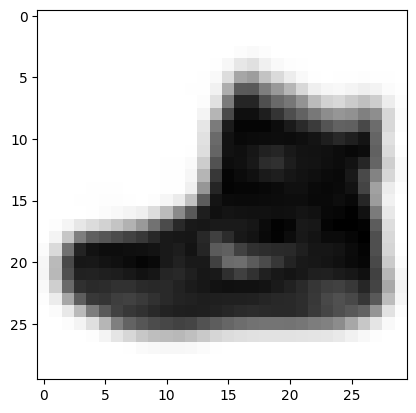

In [ ]:
my_conv_layer = MyConvLayer(in_channels=C_in, out_channels=C_out, kernel_size=KERNEL_SIZE ,stride=STRIDE ,padding=PADDING)
my_conv_layer.kernel.requires_grad = False
my_conv_layer.kernel[:] = torch.tensor([[1/16, 1/8, 1/16],
                          [1/8, 1/4, 1/8],
                          [1/16, 1/8, 1/16]])
print('img shape: ', img.shape)
img2 = my_conv_layer(img.reshape(1, 1, 28, 28))
plt.imshow(img2.detach().squeeze(), cmap='Greys');

img shape:  torch.Size([1, 1, 28, 28])
<bound method Module.parameters of Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))>
padding:  (2, 2)
stride:  (1, 1)
output shape:  torch.Size([1, 1, 30, 30])


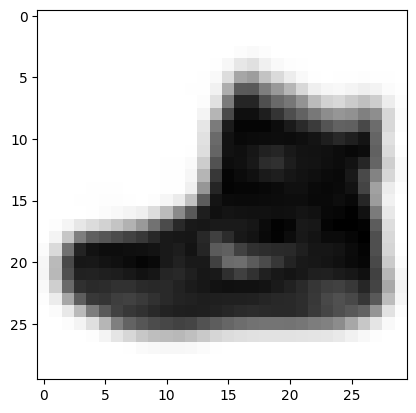

In [ ]:
pytorch_conv_layer = torch.nn.Conv2d(in_channels=C_in, out_channels=C_out, kernel_size=KERNEL_SIZE ,stride=STRIDE ,padding=PADDING)
pytorch_conv_layer.weight.data = my_conv_layer.kernel.clone().detach()
pytorch_conv_layer.weight.requires_grad = False
print('img shape: ', img.shape)
img3 = pytorch_conv_layer(img.reshape(1, 1, 28, 28))
print(pytorch_conv_layer.parameters)
print('padding: ', pytorch_conv_layer.padding)
print('stride: ', pytorch_conv_layer.stride)
print('output shape: ', img3.shape)

plt.imshow(img3.detach().squeeze(), cmap='Greys');

# **Q3 - Transfer Learning**

Transfer learning - using a network that has been trained on one data set to classify data from another data set.

# **Q3 - Section A:**

In [ ]:
# Matching the new input images to the images on which the network was originally trained and Load the CIFAR-10 dataset.
BATCH_SIZE = 256
training_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

cifar10_train_data = torchvision.datasets.CIFAR10(root="/CIFAR-10", train=True, download=True, transform=training_transform)
cifar10_test_data = torchvision.datasets.CIFAR10(root="/CIFAR-10", train=False, transform=training_transform)

cifar10_classes = cifar10_train_data.classes

cifar10_train_dataloader = DataLoader(cifar10_train_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
cifar10_test_dataloader = DataLoader(cifar10_test_data, batch_size=BATCH_SIZE)  



100%|██████████| 170498071/170498071 [00:13<00:00, 12481573.43it/s]


Extracting /CIFAR-10/cifar-10-python.tar.gz to /CIFAR-10


# **Q3 - Section C:**

Files already downloaded and verified
100 samples after 165 iterations 


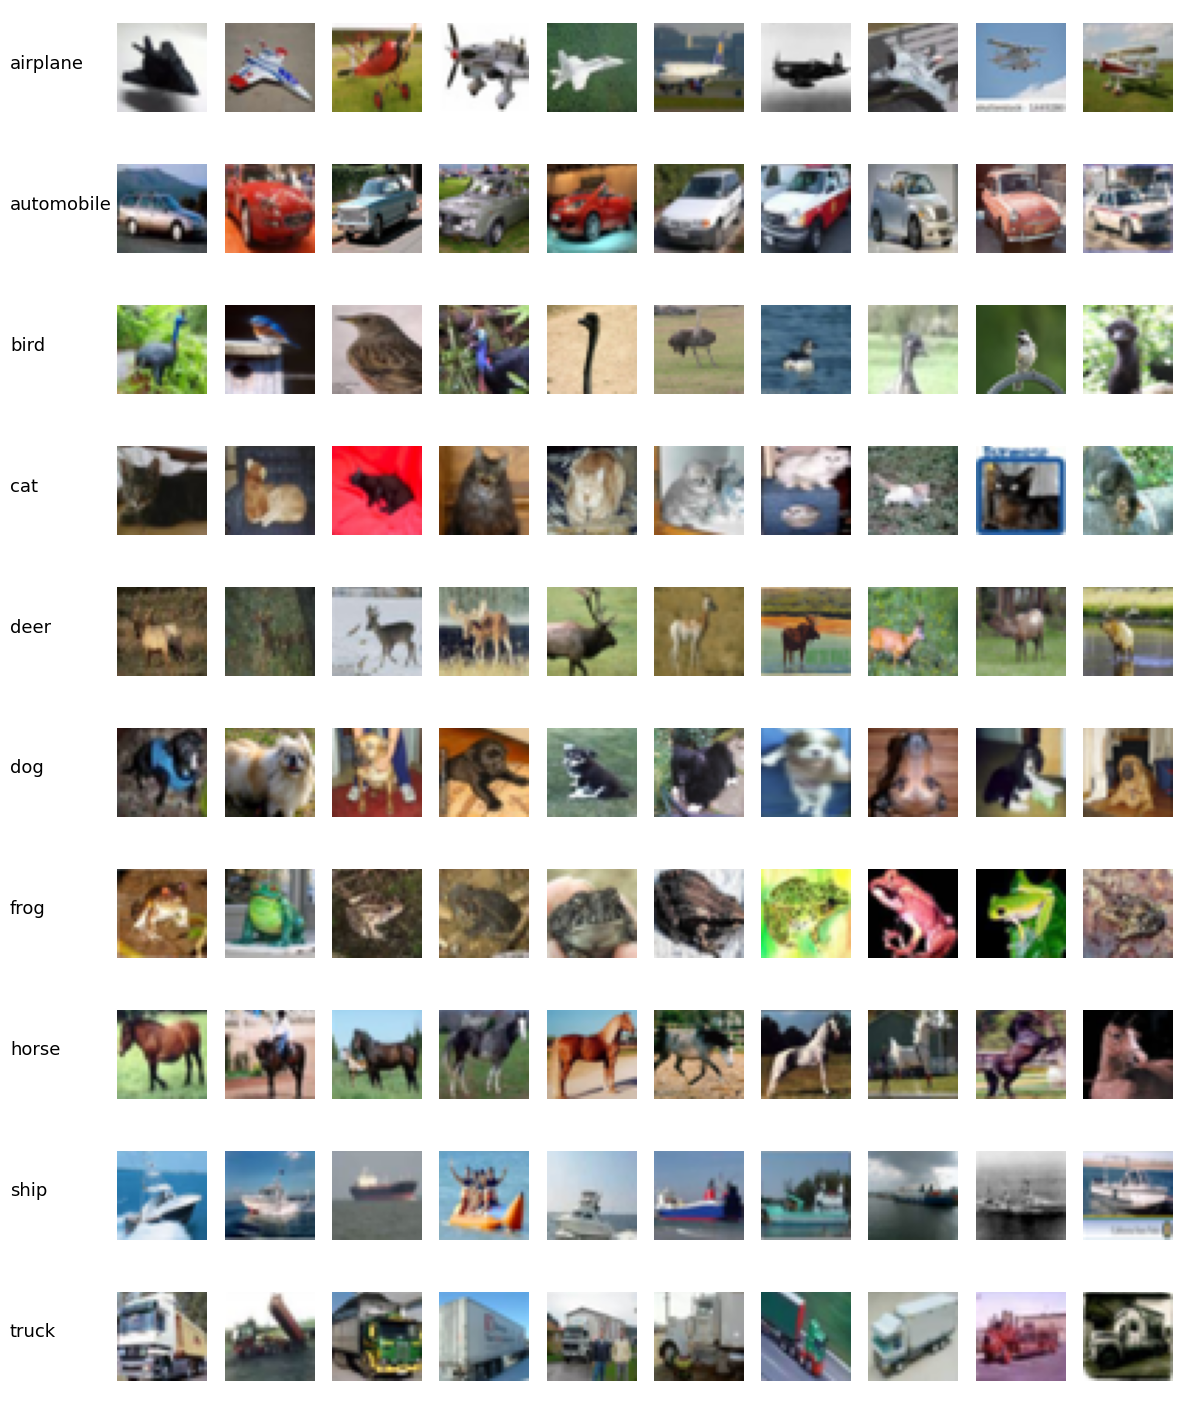

In [ ]:
data = torchvision.datasets.CIFAR10(root="/CIFAR-10", train=True, download=True)

plt.figure(figsize=(15,18))

num_of_samples_by_class = [0] * 10
for i_class in range(10):
    plt.subplot(10, 11, i_class * 11 + 1)
    plt.axis('off')
    plt.text(0, 0.5, data.classes[i_class], fontsize=13)

for sample in range(len(data.targets)): 
    img, label = data[sample]
    if num_of_samples_by_class[label] == 10:
        continue
    plt.subplot(10, 11, label*11 + num_of_samples_by_class[label]+2)
    plt.axis('off')
    plt.imshow(img)
    num_of_samples_by_class[label] += 1
    
    if sum(num_of_samples_by_class) == 100:
        print('100 samples after {} iterations '.format(sample))
        break

plt.show()

# **Q3 - Section D:**

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 224MB/s]


# **Q3 - Section E:**

Replace the fully-connected classifier of resnet18 with one that fit for CIFAR-10 dataset.


In [ ]:
# View of the network layers .
YES = 1
NO = 0

def get_network_layers(network, to_print_module=YES):
    layers_list=[]
    for name, module in network.named_children():
          layers_list.append(name)
          if to_print_module == YES:
              print('Layer Name:   ', name)
              print('Layer Module:   ', module)
              print('-------------------------------------------------')
    
    if to_print_module == NO:
        return layers_list

get_network_layers(resnet18, to_print_module=YES)


Layer Name:    conv1
Layer Module:    Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
-------------------------------------------------
Layer Name:    bn1
Layer Module:    BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
-------------------------------------------------
Layer Name:    relu
Layer Module:    ReLU(inplace=True)
-------------------------------------------------
Layer Name:    maxpool
Layer Module:    MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
-------------------------------------------------
Layer Name:    layer1
Layer Module:    Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(6

In [ ]:
resnet18_in_features = resnet18.fc.in_features
cifar10_out_features = len(cifar10_classes)
print('The parameters of the last layer before the replacement: ', resnet18.fc)
resnet18.fc = nn.Linear(in_features=resnet18_in_features, out_features=cifar10_out_features)
print('The parameters of the last layer after the replacement: ', resnet18.fc)

The parameters of the last layer before the replacement:  Linear(in_features=512, out_features=1000, bias=True)
The parameters of the last layer after the replacement:  Linear(in_features=512, out_features=10, bias=True)


# **Q3 - Section F:**

Train Neural network to identify the classes of the CIFAR-10 dataset.   
  But we will only train the new classification head,
and the rest of the parameters of the network will not change.

In [ ]:
def train_network(model, CE_loss, optimizer, NUM_OF_EPOCHS=10):
    
    model.train()
    def iterate_batch(imgs, labels):  # Iteration of the training loop
         
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()  # Reset the gradient of the parameters
       # model.train()
        y_model = model(imgs)  # Entering the data into the network and calculating predicted probabilities
        loss = CE_loss(y_model, labels)  # Calculate the loss function on current minibatch.
        loss.backward()  # Calculation of the random gradient
        optimizer.step()  # update values of (Weights, bias)

        """ Let's convert the vector of probabilities into an unequivocal classification:
            We will use argmax(vector_probabilities) and assume that the model classifies each given sample to
            the class with the highest probability in its output """
        predicted_labels = y_model.argmax(dim=1)
        acc = (predicted_labels == labels).sum() / len(labels)  # acc = the proportion of samples that the model classifies correctly.
        return loss.detach(), acc.detach()

    def iterate_epoch():
        num_of_train_batches = len(cifar10_train_dataloader)  # total number of batches = math.ceil(len(data_table)/BATCH_SIZE)
        running_loss = 0.
        running_acc = 0.

        for imgs, labels in cifar10_train_dataloader:
            #model.train()
            batch_loss, batch_acc = iterate_batch(imgs, labels)
            running_loss += batch_loss
            running_acc += batch_acc
        loss = running_loss / num_of_train_batches
        acc = running_acc / num_of_train_batches
        return loss, acc

  
    loss_train = torch.zeros(NUM_OF_EPOCHS)  # Tensor of 0's in size = num_of_epochs
    acc_train = torch.zeros(NUM_OF_EPOCHS)  # Tensor of 0's in size = num_of_epochs
            
    for epoch_idx in tqdm(range(NUM_OF_EPOCHS)):
        loss_train[epoch_idx], acc_train[epoch_idx] = iterate_epoch()

    print(f'Results on train set:\n', f'\tloss = {loss_train}\n', f'\taccuracy = {acc_train}\n')      
 
    return loss_train, acc_train   

 

In [ ]:
resnet18 = resnet18.to(device)

In [ ]:
ce_loss = nn.CrossEntropyLoss()

""" The optimization object will receive only the parameters on which we will perform the learning process, i.e. the last layer 'fc' """
optimizer_fc = optim.SGD(resnet18.fc.parameters(), lr=0.01)

loss_train_5, acc_train_5 = train_network(resnet18, ce_loss, optimizer_fc, NUM_OF_EPOCHS=10)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.1

Results on train set:
 	loss = tensor([1.4069, 0.8803, 0.7661, 0.7093, 0.6770, 0.6546, 0.6382, 0.6253, 0.6148,
        0.6057])
 	accuracy = tensor([0.5953, 0.7459, 0.7650, 0.7769, 0.7830, 0.7877, 0.7905, 0.7955, 0.7965,
        0.7990])



In [ ]:
def plot_acc_and_loss(loss, acc, NUM_OF_EPOCHS=10):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, NUM_OF_EPOCHS + 1), loss, '-x', label="train loss")

    plt.title("CE loss");
    plt.legend()
    plt.xlabel("Epoch Number");
    plt.subplot(1, 2, 2)
    plt.plot(range(1, NUM_OF_EPOCHS + 1), acc, '-x', label="train acc");

    plt.title("Accuracy");
    plt.legend()
    plt.xlabel("Epoch Number");
    plt.show()

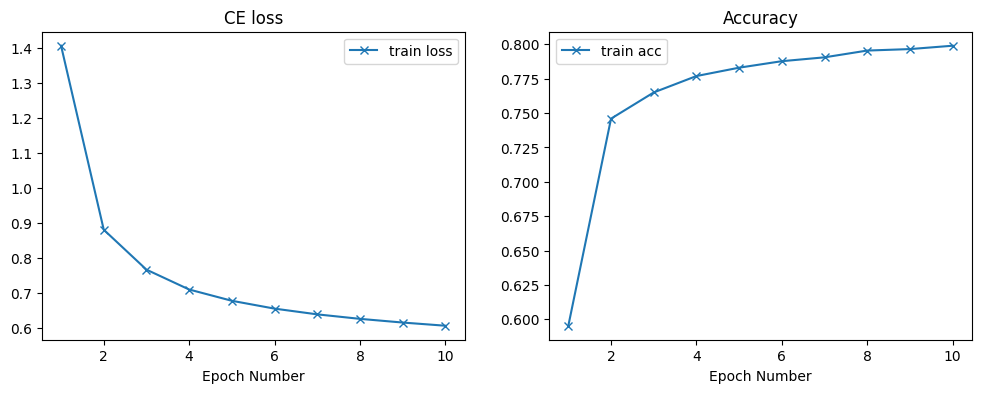

In [ ]:
plot_acc_and_loss(loss_train_5, acc_train_5, NUM_OF_EPOCHS=10)

# **Q3 - Section G:**

Now we will test the accuracy of the trained model on the test set.

In [ ]:
YES = 1
NO = 0
def test_model(model, CE_loss, save_lists=YES):

    loss_test = 0
    acc_test = 0
    num_of_test_batches = len(cifar10_test_dataloader)
    if save_lists == YES:
        batch_number = 0
        all_correct_labels = torch.zeros(len(cifar10_test_data), device=device, dtype=torch.int64)
        all_y_model = torch.zeros((len(cifar10_test_data), len(cifar10_test_data.classes)), device=device)
        all_predicted_labels = torch.zeros(len(cifar10_test_data), device=device, dtype=torch.int64)
    
    with torch.no_grad():
        model.eval()
        for data in tqdm(cifar10_test_dataloader):
            imgs, labels = data
            imgs = imgs.to(device)
            labels = labels.to(device)
            y_model = model(imgs)
            loss_test += CE_loss(y_model, labels)
            predicted_labels = y_model.argmax(dim=1)
            acc_test += (predicted_labels == labels).sum() / len(labels)
           
            if save_lists == YES:
                all_correct_labels[batch_number*BATCH_SIZE : batch_number*BATCH_SIZE + BATCH_SIZE] = labels
                all_y_model[batch_number*BATCH_SIZE : batch_number*BATCH_SIZE + BATCH_SIZE] = y_model
                all_predicted_labels[batch_number*BATCH_SIZE : batch_number*BATCH_SIZE + BATCH_SIZE] = predicted_labels
                batch_number += 1
      
    loss, acc = loss_test / num_of_test_batches, acc_test / num_of_test_batches
    
    if save_lists == YES:
        return loss, acc , all_y_model, all_predicted_labels, all_correct_labels
    
    return loss, acc

In [ ]:
loss_test, acc_test, all_y_model, all_predicted_labels, all_correct_labels = test_model(model=resnet18, CE_loss=ce_loss)

print('\nacc_test: ', acc_test.item())
print('loss_test: ', loss_test.item())

  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 40/40 [00:25<00:00,  1.58it/s]


acc_test:  0.790722668170929
loss_test:  0.6216017603874207


# **Q3 - Section H:**

**Find the 10 most extreme mistakes of the model:**
The images which the model classified with the highest probability, but to the wrong class.

In [ ]:
softmax = nn.Softmax(dim=1)
y_probs = softmax(all_y_model)

pred_probs = y_probs[torch.arange(y_probs.shape[0]), all_predicted_labels]
wrong_pred = (all_predicted_labels != all_correct_labels)  # If predicted class is wrong then value=True, else False.
wrong_pred_probs = pred_probs * wrong_pred  # When the prediction is wrong, the value will be the probability value, else 0.000 .
print(wrong_pred_probs)
wrongest_10_predictions = torch.topk(wrong_pred_probs, k=10)  # # Take the 10 most extreme errors from 'wrong_pred_probs'.

wrongest_10_predictions

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


torch.return_types.topk(
values=tensor([0.9977, 0.9932, 0.9856, 0.9795, 0.9795, 0.9772, 0.9746, 0.9742, 0.9738,
        0.9737], device='cuda:0'),
indices=tensor([4784, 9497, 7590, 4954, 4051, 5882, 6979, 2473,  305, 1732],
       device='cuda:0'))

# **Q3 - Section I:**

Present the 10 most extreme mistakes together with the wrong class that the model classified the image, and the correct class too.

---------- 0 ----------------
sample_pred_prob:  tensor(0.9977, device='cuda:0')
sample_index:  tensor(4784, device='cuda:0')
wrong_label_pred:  tensor(8, device='cuda:0')
wrong_class:  ship
correct_label:  0
correct_class:  airplane
---------- 1 ----------------
sample_pred_prob:  tensor(0.9932, device='cuda:0')
sample_index:  tensor(9497, device='cuda:0')
wrong_label_pred:  tensor(6, device='cuda:0')
wrong_class:  frog
correct_label:  3
correct_class:  cat
---------- 2 ----------------
sample_pred_prob:  tensor(0.9856, device='cuda:0')
sample_index:  tensor(7590, device='cuda:0')
wrong_label_pred:  tensor(4, device='cuda:0')
wrong_class:  deer
correct_label:  2
correct_class:  bird
---------- 3 ----------------
sample_pred_prob:  tensor(0.9795, device='cuda:0')
sample_index:  tensor(4954, device='cuda:0')
wrong_label_pred:  tensor(9, device='cuda:0')
wrong_class:  truck
correct_label:  1
correct_class:  automobile
---------- 4 ----------------
sample_pred_prob:  tensor(0.9795, device

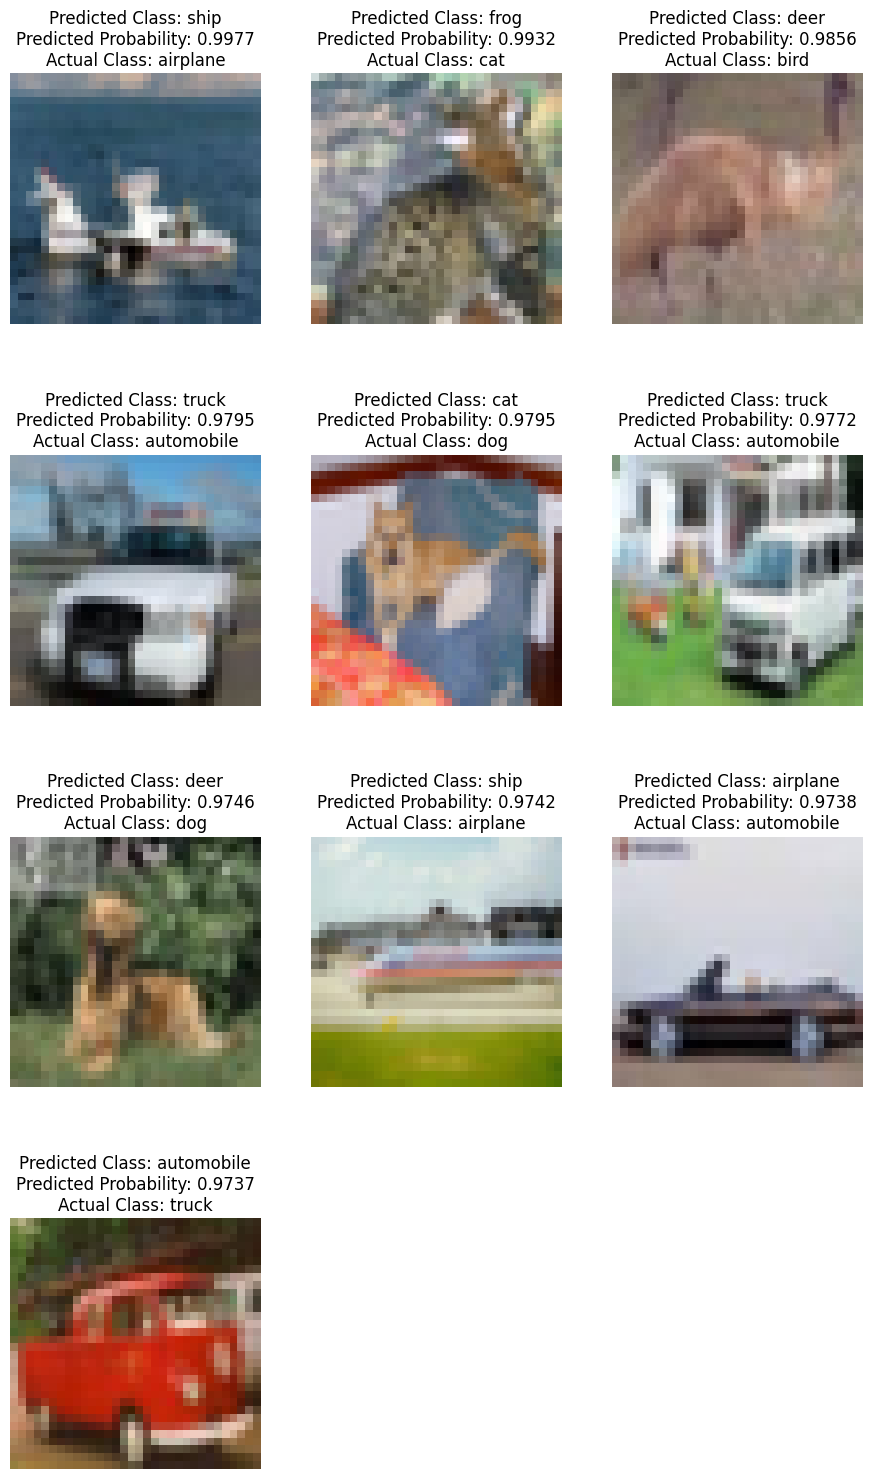

In [ ]:
wrongest_pred_probs, pred_indexs = wrongest_10_predictions

plt.figure(figsize=(11,19))

for wrong_pred in range(10): 
    print('----------', wrong_pred, '----------------')
    sample_pred_prob = wrongest_pred_probs[wrong_pred]  # The probability of the misclassified sample.
    print('sample_pred_prob: ', sample_pred_prob)
    sample_index = pred_indexs[wrong_pred]  # The index of the misclassified sample.
    print('sample_index: ', sample_index)

    wrong_label_pred = all_predicted_labels[sample_index]
    print('wrong_label_pred: ', wrong_label_pred)
    wrong_class = cifar10_classes[wrong_label_pred]
    print('wrong_class: ', wrong_class)

    img =  cifar10_test_dataloader.dataset.data[sample_index]
    
    correct_label = cifar10_test_data.targets[sample_index] 
    print('correct_label: ', correct_label)
    correct_class = cifar10_classes[correct_label]
    print('correct_class: ', correct_class)
    
    plt.subplot(4, 3, wrong_pred+1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(f'Predicted Class: {wrong_class}\n'  +
              f'Predicted Probability: {"%.4f" %(sample_pred_prob)}\n' +
              f'Actual Class: {correct_class}')

plt.show()

# **Q3 - Section J:**
Create a new model that receives the same input as the previous model.
The new model will consist of a sequence of three residual blocks that reduce the length and width dimensions, an adaptive averaging pooling layer, and a classification head.

In [ ]:
# View of the network layers .

get_network_layers(resnet18, to_print_module=YES)

Layer Name:    conv1
Layer Module:    Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
-------------------------------------------------
Layer Name:    bn1
Layer Module:    BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
-------------------------------------------------
Layer Name:    relu
Layer Module:    ReLU(inplace=True)
-------------------------------------------------
Layer Name:    maxpool
Layer Module:    MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
-------------------------------------------------
Layer Name:    layer1
Layer Module:    Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(6

In [ ]:
""" Taken from Idan Alter's Jupiter notebook.
    Idan-Alter / OU-22961-Deep-Learning  / 22961_5_7_ResNet.ipynb 

    ResBlockDownSamp: 
      In this block we will reduce the height and width by half,
      While the number of channels doubles itself (this is done by: stride =  2).
     """

class ResBlockDownSamp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #out_channels = in_channels*2                                                            
        
        self.conv1 = nn.Conv2d(in_channels, out_channels,3, padding=1, stride=2, bias=False)          
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU()
       
        self.conv2 = nn.Conv2d(out_channels, out_channels,3, padding="same", bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        
        self.downsampX = nn.Conv2d(in_channels, out_channels,1, stride=2, bias=False) 
    
    def forward(self, X):  # X.shape = N x C x H x W
        
        Y1  = self.conv1(X)  # Y1.shape = N x 2C x H/2 x W/2  ; Assuming that the hight and width dimensions were even values.
        Y1  = self.bn1(Y1)         
        Y1  = self.relu(Y1)
        
        Y1  = self.conv2(Y1)   # Y1.shape = N x 2C x H/2 x W/2
        Y1  = self.bn2(Y1)

        Y2  = Y1 + self.downsampX(X)
                                   
        Y   = self.relu(Y2)
        return Y

In [ ]:

class MyResNet(nn.Module):
    def __init__(self, in_channels):

        super().__init__()
        block = ResBlockDownSamp
        
        """ Creating three residual blocks that reduce the height and width dimensions """
        self.layer1 = self._make_block(block, in_channels, 64)
        self.layer2 = self._make_block(block, 64, 128)
        self.layer3 = self._make_block(block, 128, 256)
         
        """ Creating an adaptive averaging pooling layer """
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        """ Creating a classification head """
        self.fc = nn.Linear(256 , len(cifar10_classes))
 
           
    def _make_block(self, block, in_channels, out_channels):
        curr_block = block(in_channels, out_channels)
        #return nn.Sequential(curr_block)
        return curr_block
  

    def _forward_impl(self, x):      
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)   
        x = self.fc(x)
        return x
    

    def forward(self, x):
        return self._forward_impl(x)



In [ ]:
my_resnet_model = nn.Sequential(MyResNet(3))
my_resnet_model.to(device)

Sequential(
  (0): MyResNet(
    (layer1): ResBlockDownSamp(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsampX): Conv2d(3, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
    )
    (layer2): ResBlockDownSamp(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsampX): Conv2d(64, 128, 

# **Q3 - Section J_a:**
Train the new model.

In [ ]:
new_ce_loss = nn.CrossEntropyLoss()
new_optim = torch.optim.SGD(my_resnet_model.parameters(), lr=0.01)
new_loss_train, new_acc_train = train_network(my_resnet_model, new_ce_loss, new_optim, NUM_OF_EPOCHS=10)

100%|██████████| 10/10 [28:35<00:00, 171.58s/it]

Results on train set:
 	loss = tensor([1.7756, 1.4849, 1.3227, 1.2232, 1.1529, 1.0959, 1.0369, 0.9940, 0.9526,
        0.9091])
 	accuracy = tensor([0.3456, 0.4641, 0.5287, 0.5651, 0.5890, 0.6122, 0.6355, 0.6498, 0.6641,
        0.6797])



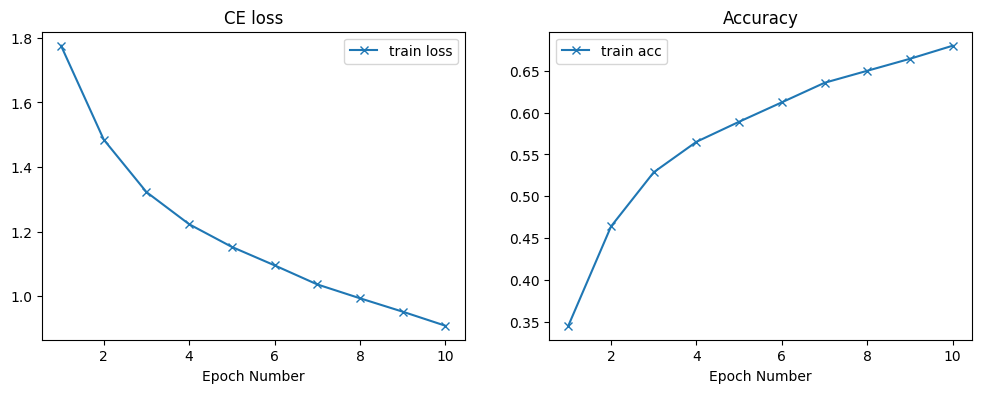

In [ ]:
plot_acc_and_loss(new_loss_train, new_acc_train, NUM_OF_EPOCHS=10)

In [ ]:
loss_test1, acc_test1 = test_model(model=my_resnet_model, CE_loss=new_ce_loss, save_lists=NO)

print('\nacc_test: ', acc_test1.item())
print('loss_test: ', loss_test1.item())

100%|██████████| 40/40 [00:25<00:00,  1.56it/s]


acc_test:  0.5015625357627869
loss_test:  1.470476746559143


# **Q3 - Section J_b:**
Comparing the results obtained from the two models.

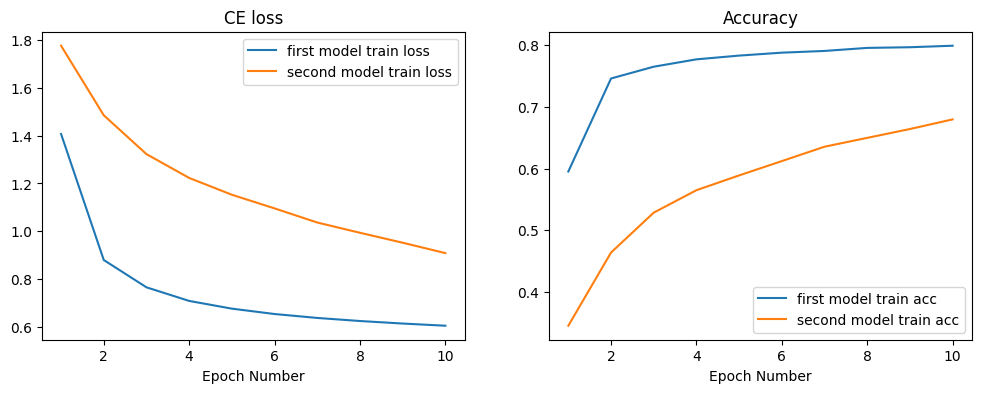

In [ ]:
NUM_OF_EPOCHS = 10
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_OF_EPOCHS+1), loss_train_5, label="first model train loss");
plt.plot(range(1, NUM_OF_EPOCHS+1), new_loss_train, label="second model train loss");
plt.title("CE loss");
plt.legend()
plt.xlabel("Epoch Number");
plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_OF_EPOCHS+1), acc_train_5, label="first model train acc");
plt.plot(range(1, NUM_OF_EPOCHS+1), new_acc_train, label="second model train acc");
plt.title("Accuracy");
plt.legend()
plt.xlabel("Epoch Number");
plt.show()